In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data from a JSON file
data = []
with open('Data/reviews.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
# Convert data into a pandas DataFrame
df=pd.DataFrame(data)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [4]:
# Column names in the DataFrame
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [5]:
# Generate descriptive statistics
df.describe()

,overall,unixReviewTime
count,194439.000000,1.944390e+05
mean,4.129912,1.368714e+09
std,1.222499,3.230032e+07
min,1.000000,9.828000e+08
25%,4.000000,1.357603e+09
50%,5.000000,1.374538e+09
75%,5.000000,1.390262e+09
max,5.000000,1.406074e+09


In [6]:
# Shape of the DataFrame
df.shape

(194439, 9)

In [7]:
# Check for missing values in each column
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      3519
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

# Overview of the data

### Columns:
  - `reviewerID`: Unique ID for the reviewer
  - `asin`: Amazon Standard Identification Number, a unique code for the product
  - `reviewerName`: Name of the reviewer
  - `helpful`: Array indicating [number of helpful votes, total votes]
  - `reviewText`: Text of the review
  - `overall`: Rating given by the reviewer
  - `summary`: Short summary of the review
  - `unixReviewTime`: Time of the review in UNIX timestamp format
  - `reviewTime`: Human-readable review time

### Summary Statistics:
- **Data Counts**: 194439 entries
- **Missing Data**: There are 3519 review without reviewer names.
- **Overall Ratings**: Ratings range from 1 to 5, with an average of approximately 4.12.

### Next Steps for Data Wrangling and EDA:
1. **Data Cleaning**:
   - Address missing values where necessary
   - Convert the `helpful` column to a more usable integer column for analysis.
   - Convert `unixReviewTime` to a more readable date format.

2. **Exploratory Data Analysis (EDA)**:
   - Distribution of ratings (`overall`).
   - Trends over time (using `reviewTime`).
   - Text analysis of `reviewText` and `summary` for common themes.
   - Analysis of helpfulness ratings to see how they correlate with review ratings.

In [8]:
# Handle missing values and data type conversions
df['reviewerName'].fillna('Unknown', inplace=True)
df['reviewerName'].isnull().sum()

0

In [9]:
df['helpful'] = df['helpful'].astype(str)
df[['helpful_votes', 'total_votes']] = df['helpful'].str.extract(r'\[(\d+), (\d+)\]')
df[['helpful_votes', 'total_votes']] = df[['helpful_votes', 'total_votes']].fillna(0)
df[['helpful_votes', 'total_votes']] = df[['helpful_votes', 'total_votes']].astype(int)
df['helpfulness_score'] = np.where(df['total_votes'] > 0, 
                                     (df['helpful_votes'] / df['total_votes']) * 100, 
                                     np.nan)
df['helpfulness_score'].head(15)

0            NaN
1            NaN
2            NaN
3     100.000000
4      66.666667
5      50.000000
6            NaN
7      50.000000
8      66.666667
9     100.000000
10           NaN
11     66.666667
12    100.000000
13     75.000000
14    100.000000
Name: helpfulness_score, dtype: float64

In [10]:
df['reviewDate'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df['reviewDate'].head()

0   2014-05-21
1   2014-01-14
2   2014-06-26
3   2013-10-21
4   2013-02-03
Name: reviewDate, dtype: datetime64[ns]

In [11]:
# Clean up DataFrame by dropping unnecessary columns
df.drop(['helpful','helpful_votes','total_votes','unixReviewTime','reviewTime'], axis=1, inplace=True)
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'reviewText', 'overall',
       'summary', 'helpfulness_score', 'reviewDate'],
      dtype='object')

In [12]:
df.head(10)

,reviewerID,asin,reviewerName,reviewText,overall,summary,helpfulness_score,reviewDate
0,A30TL5EWN6DFXT,120401325X,christina,They look good and stick good! I just don't li...,4.0,Looks Good,NaN,2014-05-21
1,ASY55RVNIL0UD,120401325X,emily l.,These stickers work like the review says they ...,5.0,Really great product.,NaN,2014-01-14
2,A2TMXE2AFO7ONB,120401325X,Erica,These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,NaN,2014-06-26
3,AWJ0WZQYMYFQ4,120401325X,JM,Item arrived in great time and was in perfect ...,4.0,Cute!,100.000000,2013-10-21
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,66.666667,2013-02-03
5,APX47D16JOP7H,120401325X,RLH,These make using the home button easy. My daug...,3.0,Cute,50.000000,2013-10-12
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,Came just as described.. It doesn't come unstu...,5.0,best thing ever..,NaN,2013-08-22
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,it worked for the first week then it only char...,1.0,not a good Idea,50.000000,2013-11-21
8,A2JWEDW5FSVB0F,3998899561,Adam,"Good case, solid build. Protects phone all aro...",5.0,Solid Case,66.666667,2013-09-25
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,This is a fantastic case. Very stylish and pro...,5.0,Perfect Case,100.000000,2014-04-03


In [13]:
# Create a new column 'rating' based on the 'overall' column to classify reviews
df['rating'] = ''  
df.loc[df['overall'] >= 3, 'rating'] = 'Good'
df.loc[df['overall'] <= 3, 'rating'] = 'Bad'
df.loc[df['overall'] == 3, 'rating'] = 'Neutral'

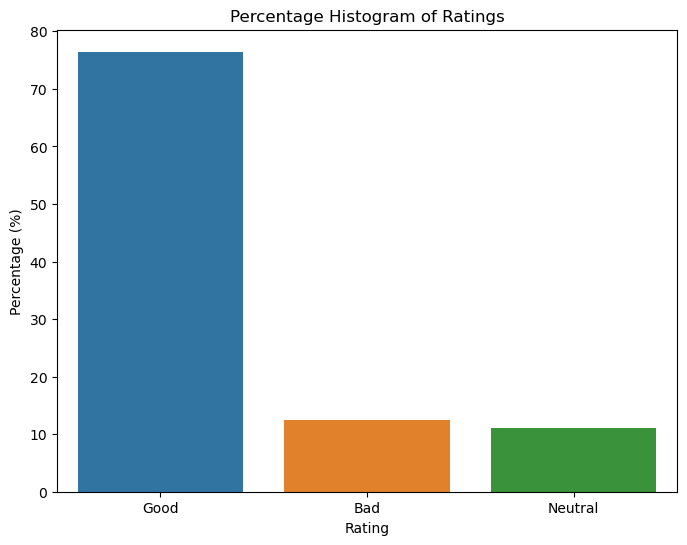

In [14]:
# Calculate and plot the percentage distribution of ratings
rating_counts = df['rating'].value_counts()
rating_percent = (rating_counts / rating_counts.sum()) * 100

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_percent.index, y=rating_percent.values)
plt.title('Percentage Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.show()

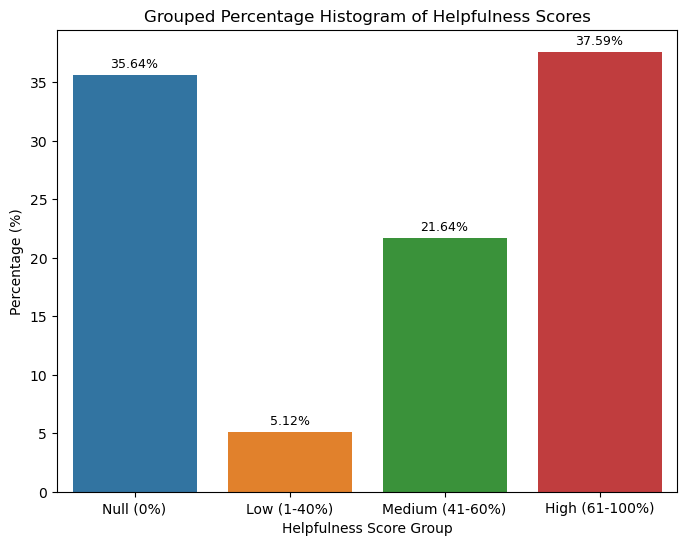

In [15]:
# Analysis of the helpfulness scores
custom_bins = [0, 1, 40, 60, 100]
custom_labels =['Null (0%)', 'Low (1-40%)', 'Medium (41-60%)', 'High (61-100%)']
helpfulness_data = df['helpfulness_score']
helpfulness_categories = pd.cut(helpfulness_data, bins=custom_bins, labels=custom_labels, right=False)
helpfulness_grouped_counts = helpfulness_categories.value_counts(sort=False)
helpfulness_grouped_percent = (helpfulness_grouped_counts / helpfulness_grouped_counts.sum()) * 100
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=helpfulness_grouped_percent.index, y=helpfulness_grouped_percent.values)
plt.title('Grouped Percentage Histogram of Helpfulness Scores')
plt.xlabel('Helpfulness Score Group')
plt.ylabel('Percentage (%)')
for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_height(), '.2f') + '%', 
                      (bar.get_x() + bar.get_width() / 2, 
                       bar.get_height()), ha='center', va='center',
                       size=9, xytext=(0, 8),
                       textcoords='offset points')
plt.show()

### 1. Percentage Histogram of Ratings (Overall)
This graph shows the distribution of ratings given by users on a scale of 1 to 5:

- **High Ratings Dominance:** A significant portion of the ratings are 4s and 5s, with these two categories combined making up a large majority of all ratings. This suggests that users are generally satisfied with the products they are reviewing.
- **Positive Skew:** The distribution of ratings is positively skewed, meaning that there are fewer low ratings (1s and 2s) compared to higher ratings. This could indicate that customers who decide to leave reviews are typically those who have had a positive experience, or it might reflect a generally good quality of products being reviewed.
- **Few Neutral and Negative Ratings:** The relatively low percentages for ratings of 3 (neutral) and particularly 1 and 2 (negative) suggest that negative experiences are less common, or users are less inclined to leave reviews following mediocre or poor experiences.

### 2. Percentage Histogram of Helpfulness Scores
This graph represents how helpful others found the reviews, on a scale from 0% to 100%:

- **High Helpfulness Scores:** There is a significant concentration of scores at 100%, indicating that many reviews are found completely helpful by those who rate them. This might suggest that reviewers are generally doing a good job of providing useful, clear, and thorough information about the products.
- **Distribution Across Scores:** Aside from the peak at 100%, the rest of the scores are distributed across the range, but with notably smaller percentages. This shows that while many reviews are highly valued, there are still a number of reviews that receive mixed evaluations on their helpfulness.
- **Low Helpfulness Less Common:** Lower helpfulness scores are notably less common, which could suggest that negative feedback on review helpfulness is relatively rare, or it could reflect a tendency of users to engage more with content they find useful, ignoring less helpful reviews.

### Overall Insight
Both graphs together give a picture of a community where positive sentiment in product reviews dominates and the reviews are frequently found helpful. This could be beneficial for potential buyers relying on these reviews to make purchasing decisions, as it suggests they are likely to encounter helpful and positive evaluations of products.

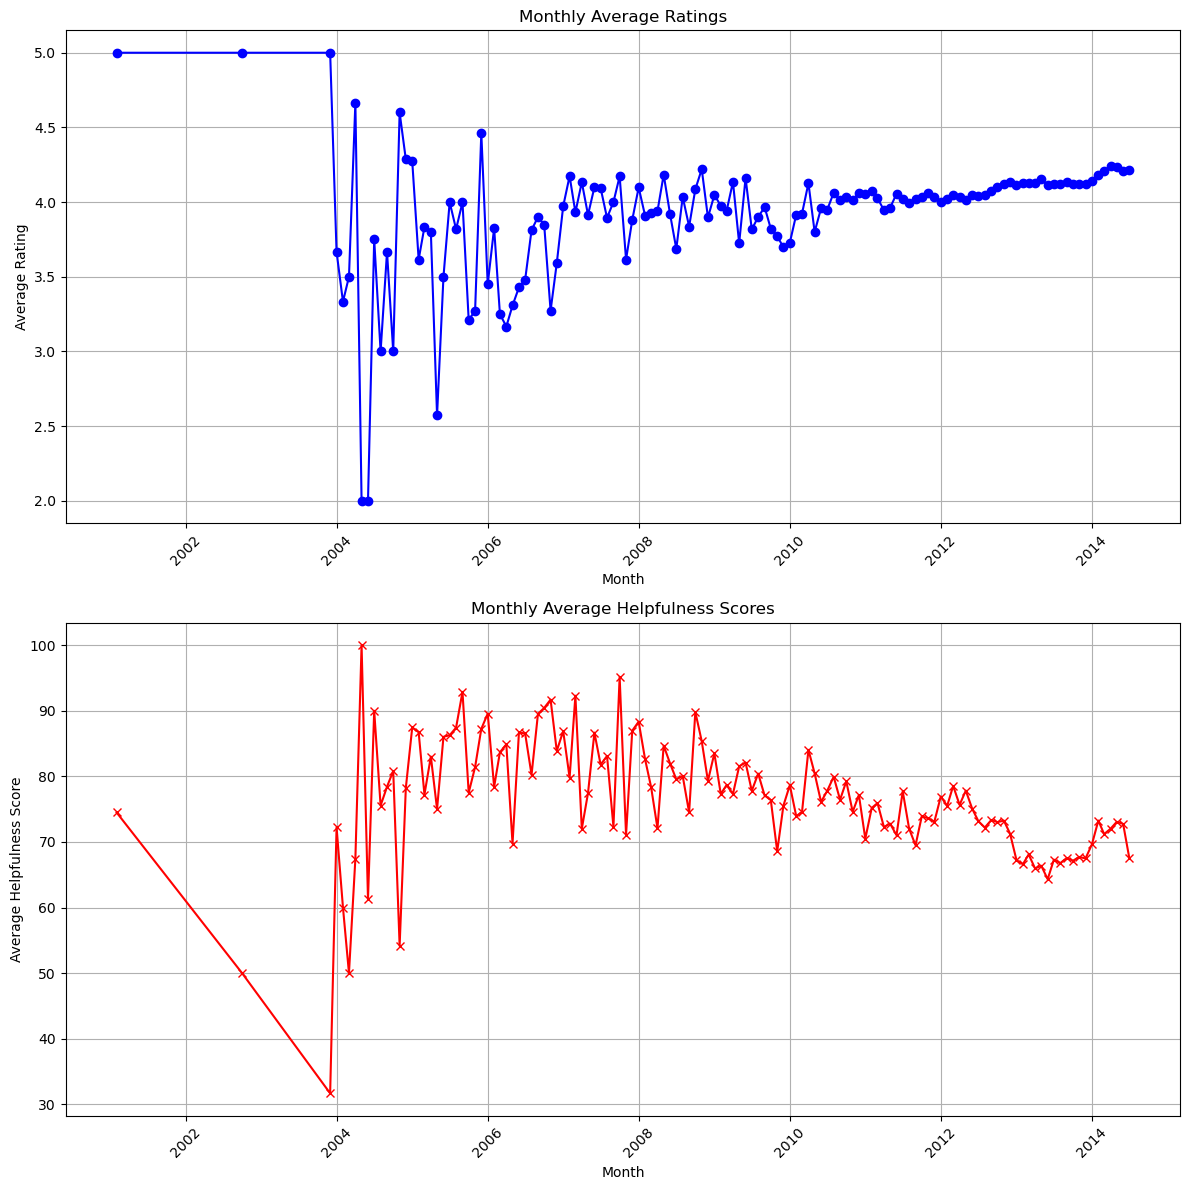

In [16]:
# Calculate and plot monthly averages for ratings and helpfulness scores from review data
monthly_avg_ratings = df.groupby(df['reviewDate'].dt.to_period("M"))['overall'].mean().reset_index()
monthly_avg_helpfulness = df.groupby(df['reviewDate'].dt.to_period("M"))['helpfulness_score'].mean().reset_index()
monthly_avg_ratings.rename(columns={'reviewDate': 'Month', 'overall': 'Average Rating'}, inplace=True)
monthly_avg_helpfulness.rename(columns={'reviewDate': 'Month', 'helpfulness_score': 'Average Helpfulness Score'}, inplace=True)
monthly_avg_ratings['Month'] = monthly_avg_ratings['Month'].dt.to_timestamp()
monthly_avg_helpfulness['Month'] = monthly_avg_helpfulness['Month'].dt.to_timestamp()
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(monthly_avg_ratings['Month'], monthly_avg_ratings['Average Rating'], 'b-o', label='Average Rating')
ax[0].set_title('Monthly Average Ratings')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Average Rating')
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)
ax[1].plot(monthly_avg_helpfulness['Month'], monthly_avg_helpfulness['Average Helpfulness Score'], 'r-x', label='Average Helpfulness Score')
ax[1].set_title('Monthly Average Helpfulness Scores')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Average Helpfulness Score')
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Function to clean review text for text analysis
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['cleaned_reviewText'] = df['reviewText'].astype(str).apply(clean_text)
df['cleaned_summary'] = df['summary'].astype(str).apply(clean_text)

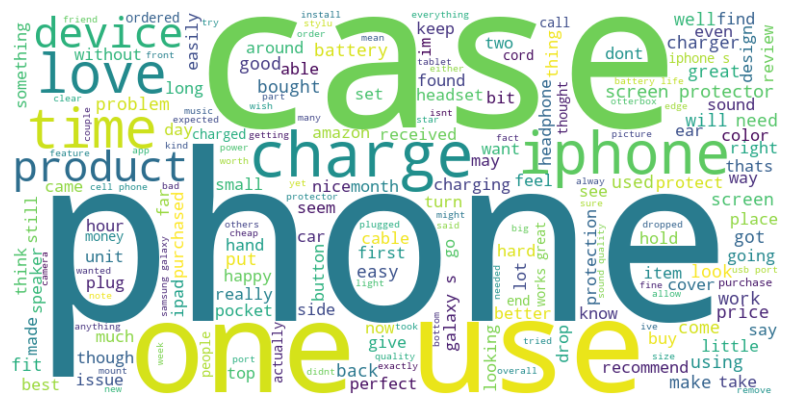

In [18]:
# Apply text cleaning function and generate word clouds
all_reviews = ' '.join(df['cleaned_reviewText'])
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(all_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

1. **Positive Sentiment**: Words like "great," "love," "good," and "nice" appear prominently, indicating a generally positive sentiment among the reviews. This suggests that many customers are satisfied with their purchases.

2. **Product Attributes**: Specific terms like "case," "screen," "phone," and "cover" are also visible. This highlights that the reviews are focused on products related to mobile phones or similar devices.

3. **Quality and Functionality**: Words such as "perfect," "easy," and "well" suggest that reviewers often comment on the quality and functionality of the products. They are likely appreciating how well the products meet their needs or how easy they are to use.

4. **Emphasis on Aesthetics**: The presence of words like "cute" and "pretty" implies that aesthetic qualities are significant to reviewers.

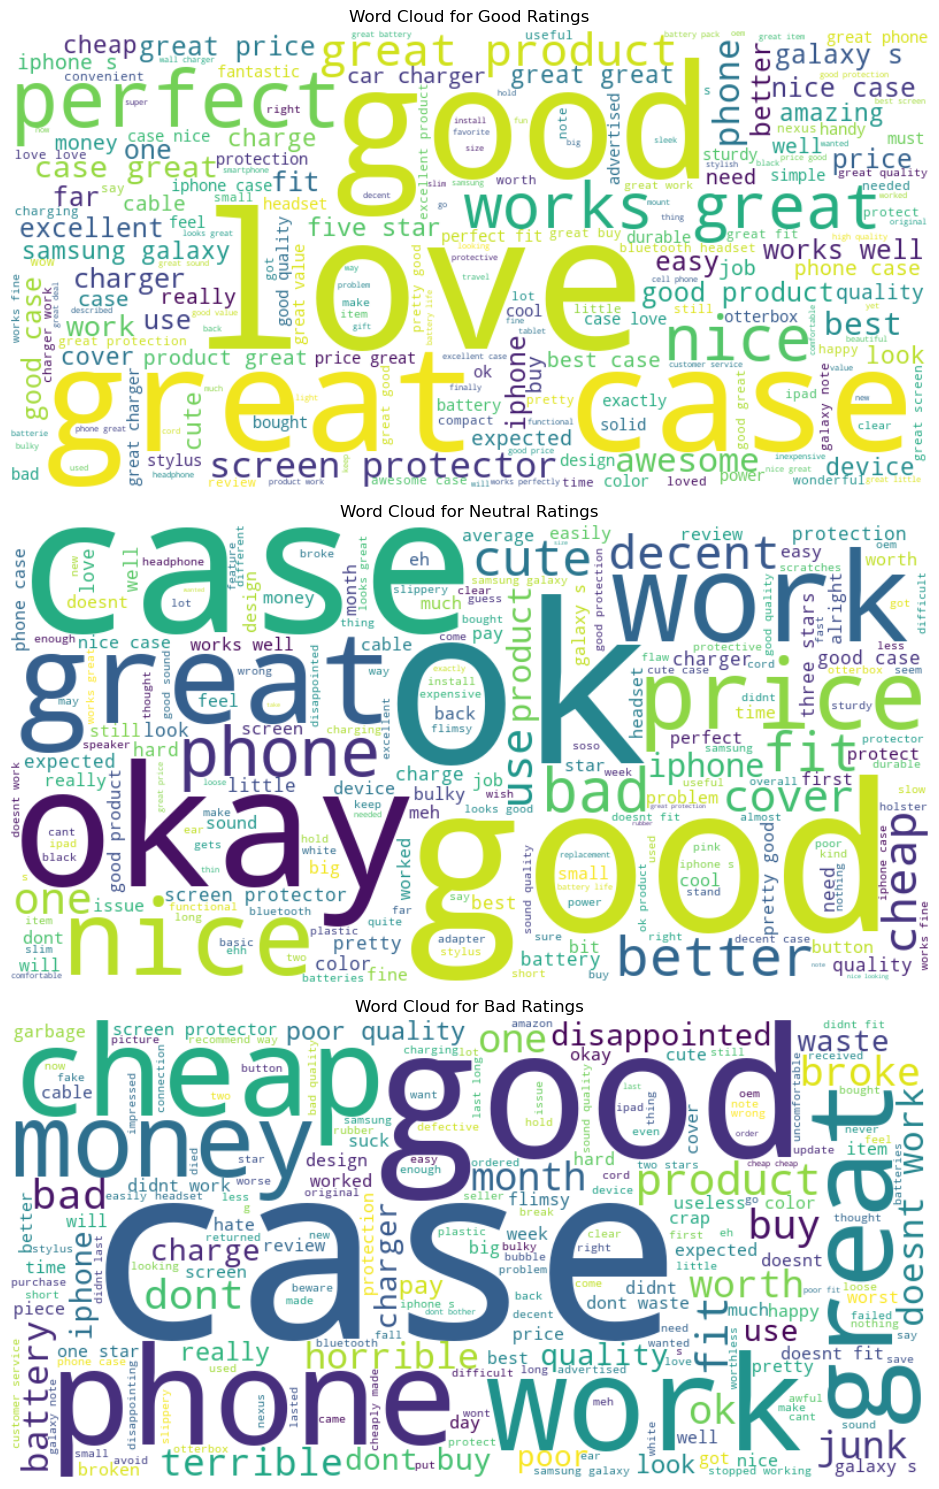

In [19]:
# Generate and display word clouds for each rating category ('Good', 'Neutral', 'Bad') based on review summaries
df['rating_category'] = pd.cut(df['overall'], bins=[0, 2, 3, 5], labels=['Bad', 'Neutral', 'Good'])
rating_categories = ['Good', 'Neutral', 'Bad']
fig, axes = plt.subplots(nrows=len(rating_categories), ncols=1, figsize=(10, 15))
for i, category in enumerate(rating_categories):
    specific_summaries = df[df['rating_category'] == category]['cleaned_summary']
    combined_text = ' '.join(specific_summaries)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f'Word Cloud for {category} Ratings')

plt.tight_layout()
plt.show()

In [20]:
# Filter the DataFrame to include only 'Neutral' and 'Bad' ratings where summaries contain the specified words
pattern = r'\b(good|great|work)\b'
filtered_data = df[
    (df['rating_category'].isin(['Neutral', 'Bad'])) &
    (df['cleaned_summary'].str.contains(pattern, case=False, regex=True))
]

# Sample a subset of the filtered data for inspection
sample_data = filtered_data.sample(n=20, random_state=1)  # Random state for reproducibility

sample_data[['reviewerID', 'overall', 'rating_category', 'summary', 'cleaned_summary']]

,reviewerID,overall,rating_category,summary,cleaned_summary
183678,AFXWHQDGO4LQD,1.0,Bad,Doesn't work with my unit,doesnt work with my unit
185239,A2B4OOWKV6QAIF,3.0,Neutral,OK but not great,ok but not great
94462,A3ODQQDGMRX3UV,3.0,Neutral,"The cover is good, but the screen protector isn't",the cover is good but the screen protector isnt
148613,A27IN57YAPDJ8S,1.0,Bad,not a good phone,not a good phone
110975,A3RKSU78ME5SO5,1.0,Bad,Cute but doesn't work well,cute but doesnt work well
49168,A1SHHQSPOWR00F,3.0,Neutral,"Great responsive tip, but too short to be useful",great responsive tip but too short to be useful
115897,A36TSGAC7RAG3D,3.0,Neutral,Great product,great product
60373,A1C6ZJNWKYK485,2.0,Bad,Doesn't work with my Verizon iPhone 4S,doesnt work with my verizon iphone s
117932,A1XW61EM17TA2K,3.0,Neutral,Great protection.....,great protection
29789,ALMBS1PLSBF6W,3.0,Neutral,The charger is great the batteries have a shor...,the charger is great the batteries have a shor...


Reviewing the sample data where 'Neutral' and 'Bad' ratings include summaries with generally positive words like 'good', 'great', or 'work', there are a few interesting observations that might seem unusual:

1. **Positive Words in Negative Contexts**: Some summaries use positive words in a context that's not entirely positive. For example:
   - "Did not work" uses "work" but in a negative sense.
   - "Not a good product." contains "good" but negates it.

2. **Misalignment of Rating and Sentiment**: There are summaries where the sentiment expressed seems more positive than the rating would suggest:
   - "Works Well if Done Properly the FIRST Time" and "Works great" are associated with a 'Neutral' rating (3.0), which might indicate some underlying issues.
   - "A good basic belt holster for the price." and "Great Protection, Pain to Keep Clean" also carry 'Neutral' ratings but contain positive descriptors like "good" and "great".

3. **Ambiguity**: Some reviews might contain ambiguities that make them difficult to categorize strictly as positive or negative based only on a few keywords:
   - "Worked for a very short while" suggests a temporary satisfaction which quickly turned unsatisfactory.
   
To improve the reflectiveness of word clouds, especially when dealing with reviews that contain positive words in negative contexts we will use Bigram or Trigram Analysis instead of using single words (unigrams)

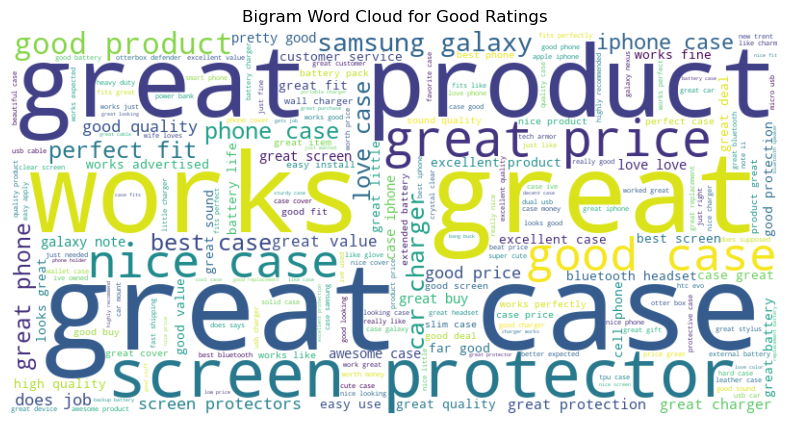

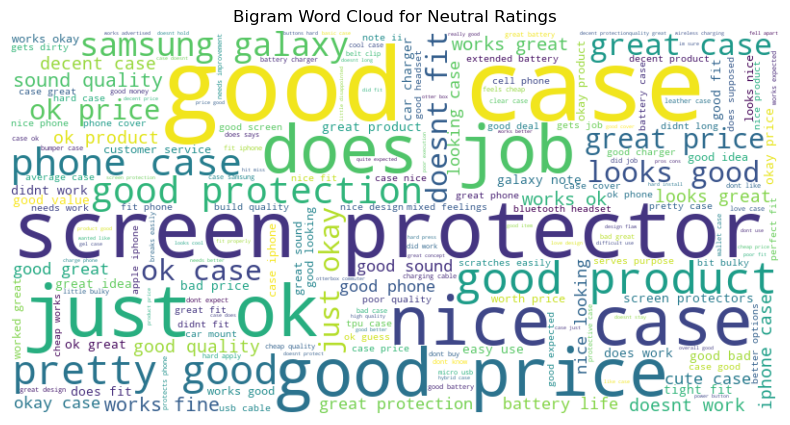

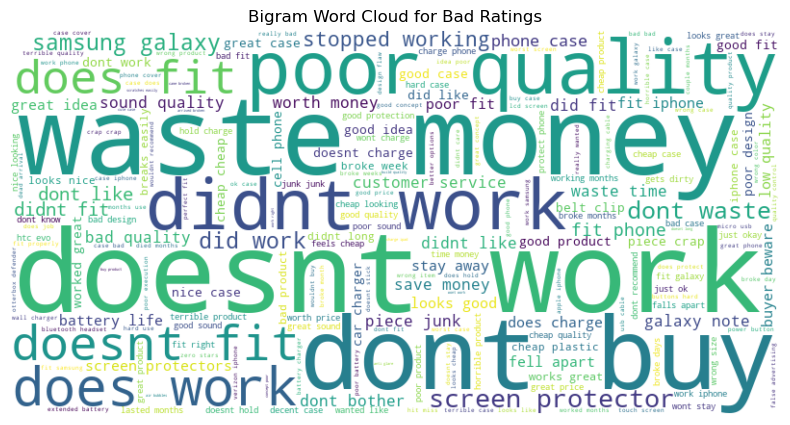

In [21]:
def generate_bigram_wordcloud(data, title):
    count_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    count_data = count_vectorizer.fit_transform(data)
    words = count_vectorizer.get_feature_names_out()
    total_counts = count_data.sum(axis=0)
    freqs = {word: total_counts[0, idx] for word, idx in zip(words, total_counts.nonzero()[1])}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

    
generate_bigram_wordcloud(df[df['rating_category'] == 'Good']['cleaned_summary'], 'Bigram Word Cloud for Good Ratings')
generate_bigram_wordcloud(df[df['rating_category'] == 'Neutral']['cleaned_summary'], 'Bigram Word Cloud for Neutral Ratings')
generate_bigram_wordcloud(df[df['rating_category'] == 'Bad']['cleaned_summary'], 'Bigram Word Cloud for Bad Ratings')

### Conclusion on Word Cloud Analysis with Bigrams

The use of bigram word clouds in analyzing the review summaries for different rating categories ('Good', 'Neutral', 'Bad') offered a deeper understanding of how certain phrases are commonly used within each context:

1. **Contextual Nuance**: Bigram analysis helped capture the context around keywords which single-word analysis might miss. This was particularly insightful for identifying how positive words like "good" and "great" are used even in 'Neutral' and 'Bad' reviews, often in more complex phrases that convey dissatisfaction or conditional praise.

2. **Identifying Trends**: The bigrams such as "not good" in 'Bad' reviews or "works great" in 'Neutral' reviews revealed a more detailed sentiment than could be gauged from single words alone. This indicates that while a product may generally meet expectations, it might still not fully satisfy users, leading to a neutral rating.

3. **Sentiment Discrepancies**: The analysis also highlighted discrepancies where the sentiment implied by the summary text did not always align with the numerical rating. For example, relatively positive phrases in 'Neutral' ratings suggest that users acknowledge some positive aspects but might have reservations that prevent a fully positive rating.